# Univariate Forecasting

In [1]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")

It is important and useful to test simple forecast strategies prior to testing more complex models. Simple forecast strategies are those that assume little or nothing about the nature of the forecast problem and are fast to implement and calculate. The results can be used as a baseline in performance and used as a point of a comparison. If a model can perform better than the performance of a simple forecast strategy, then it can be said to be skillful. 

Besides, machine learning and deep learning methods can achieve impressive results on challenging time series forecasting problems. Nevertheless, there are many forecasting problems where classical methods such as SARIMA and exponential smoothing readily outperform more sophisticated methods. Therefore, it is important to both understand how classical time series forecasting methods work and to evaluate them prior to exploring more advanced methods.

## Food Consumption Score Time-Series of the Yemen country

Let's load the time-series of the Yemen country (FCS indicator) with which we want to apply different forecasting approaches.

In [2]:
df = pd.read_excel("ts_fcs.xlsx", index_col = 0, parse_dates = True)
df.columns.name = "AdminStrata"
df.head()

AdminStrata,Abyan,Ad Dali,Aden,Al Bayda,Al Hudaydah,Al Jawf,Al Maharah,Al Mahwit,Amran,Dhamar,...,Hajjah,Ibb,Lahj,Marib,Raymah,Sa'dah,Sana'a,Sana'a City,Shabwah,Taizz
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-09-30,34.100,57.43,21.22,32.76,32.28,37.97,18.00,34.38,46.82,51.76,...,52.04,48.10,41.31,61.71,62.84,46.230000,38.25,33.43,35.22,55.37
2015-10-31,40.145,54.33,38.02,46.39,37.67,49.74,25.00,34.56,45.05,58.15,...,54.73,46.12,37.69,49.25,60.59,44.811429,40.24,36.76,42.42,57.60
2015-11-30,46.190,56.44,27.95,52.56,32.65,56.74,35.56,39.38,58.51,55.58,...,51.95,51.04,30.62,45.39,65.15,43.392857,29.66,35.96,42.41,59.83
2015-12-31,36.110,53.04,30.60,54.37,25.54,58.22,24.82,34.31,53.84,55.84,...,43.49,47.02,50.17,47.12,67.28,41.974286,50.51,42.51,51.00,55.53
2016-01-31,43.440,50.44,26.24,55.33,32.19,55.17,19.78,29.67,46.88,49.89,...,52.10,51.67,48.03,45.62,64.38,40.555714,52.91,38.82,57.95,62.71


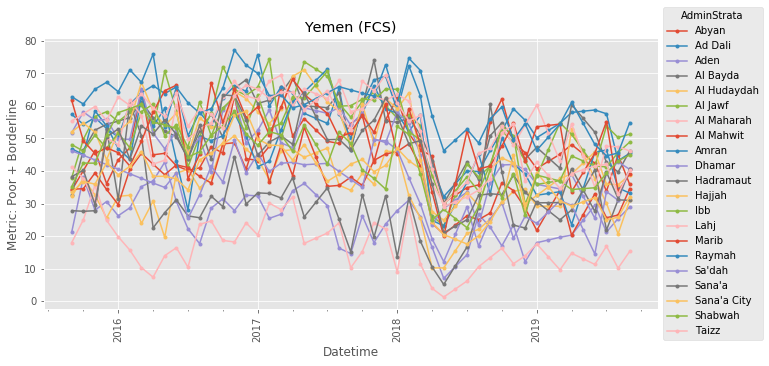

In [3]:
# Show the time-series to use.
f = plt.figure(figsize = (11, 5))
plt.title("Yemen (FCS)", color = "black")
df.plot(ax = f.gca(), style = ".-")
plt.legend(title = "AdminStrata", loc = "center left", bbox_to_anchor = (1.0, 0.5))
plt.ylabel("Metric: Poor + Borderline")
plt.xticks(rotation = 90)
plt.autoscale()
plt.show()

In [4]:
# Let's define the number of observation we want to predict.
num_predictions = 10
# Let's define the 'train' and 'test' sets.
num_train = len(df) - num_predictions
df_train = df[:num_train]
df_test = df[num_train:]
print("The number of points used to forecast is:", len(df_train))
print("The number of points to use for testing the forecast is:", len(df_test))

The number of points used to forecast is: 39
The number of points to use for testing the forecast is: 10


In [5]:
dates_to_forecast = df_test.index
dates_to_forecast.array

<DatetimeArray>
['2018-12-31 00:00:00', '2019-01-31 00:00:00', '2019-02-28 00:00:00',
 '2019-03-31 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00',
 '2019-06-30 00:00:00', '2019-07-31 00:00:00', '2019-08-31 00:00:00',
 '2019-09-30 00:00:00']
Length: 10, dtype: datetime64[ns]

## Tools

In [6]:
# Define the dictionary where save the results of all the forecast methods tried.
results_forecast = dict()

In [7]:
def mae(time_series_predict, df_test): 
    AdminStrata = time_series_predict.name
    mae = mean_absolute_error(df_test[AdminStrata], time_series_predict)
    return mae

In [8]:
# In such case the stationarity of the time-series is required so we render stationary the time-series that need it.
def make_stationary(time_series):
    n_diff = 0
    outputs = adfuller(time_series)
    p_value = outputs[1]
    while p_value > 0.05:
        # Subtract shift.
        time_series = time_series - time_series.shift()
        time_series.dropna(inplace = True)
        outputs = adfuller(time_series)
        p_value = outputs[1]
        n_diff += 1
    return time_series, n_diff

In [9]:
# Inverting trasformation.
def inverting_difference(time_series, df_train, n_diff):
    if n_diff == 1:
        return df_train[time_series.name].iloc[-1] + time_series.cumsum()
    if n_diff == 0:
        return time_series

## 1.  Naive Forecast

Naive model is a persistence model that simply uses the last observation of the corresponding time-series as prediction of the next time step. Given a time-series $X = \{x_1, x_2, ..., x_t\}$, let's suppose to want to predict the next $x_{t + 1}$ value.
The Naive model chooses as prediction:

$$\hat{y} = x_t$$

where $\hat{y}$ is the prediction for the $x_{t + 1}$ value.

This simple approach can be adjusted slightly for seasonal data. In this case, the observation at the same time in the previous cycle may be persisted instead. This can be further generalized to testing each possible offset into the historical data that could be used to persist a value for a forecast. For example, setting the offset not to the last observation but to quintultimate observation:

$$\hat{y} = x_{t - 5}$$

Let's search for the best $n$ parameter (previous lags for the Naive method) of each AdminStrata using a grid search.

In [10]:
def evaluate_naive_forecast(time_series, n):
    for i in range(num_predictions):
        # Make prediction.
        y_hat = time_series[-n] 
        y_hat = pd.Series(y_hat, index = [dates_to_forecast[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    # Calculate out of samples error.
    y_hats = time_series[-num_predictions:]
    error = mean_absolute_error(df_test[time_series.name], y_hats)
    return error, n, y_hats

In [11]:
def naive_forecast(time_series):    
    n_list = len(time_series)
    best_score, best_n, best_y_hats = float("inf"), None, None
    # Grid search for the best n parameter.
    for n_ in range(1, n_list + 1):
        try:
            error, n, y_hats = evaluate_naive_forecast(time_series, n_)
            if error < best_score:
                best_score, best_n, best_y_hats = error, n, y_hats
        except:
            continue    
    return best_score, best_n, best_y_hats

In [12]:
df_train_copy = df_train.copy()
results = df_train_copy.apply(naive_forecast)
err = np.mean([x[0] for x in results])
err

4.918785714285714

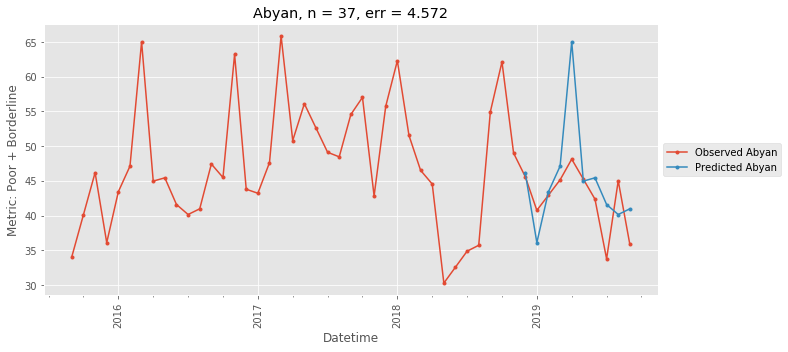

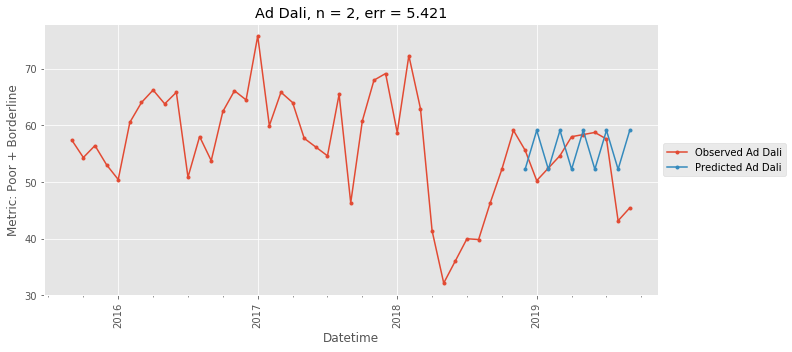

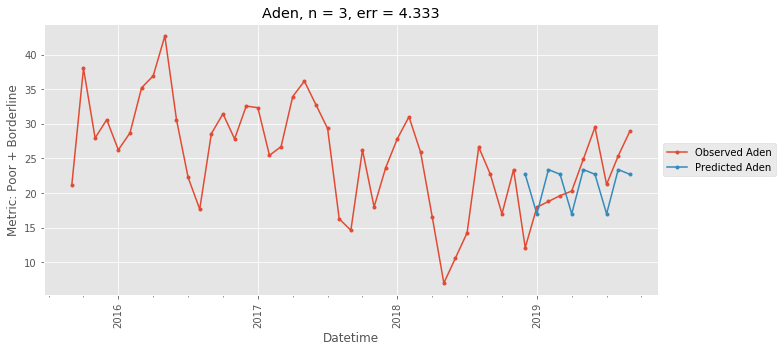

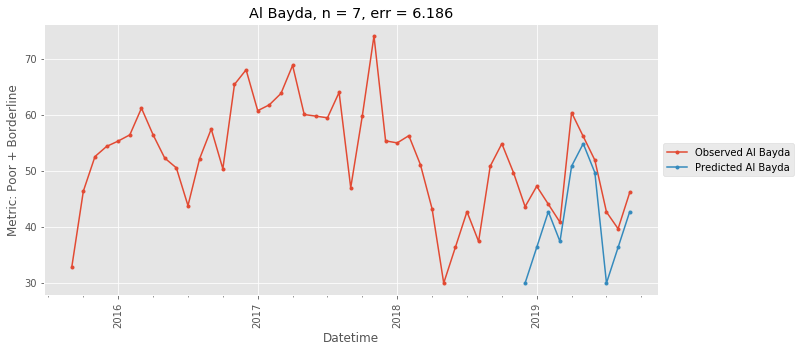

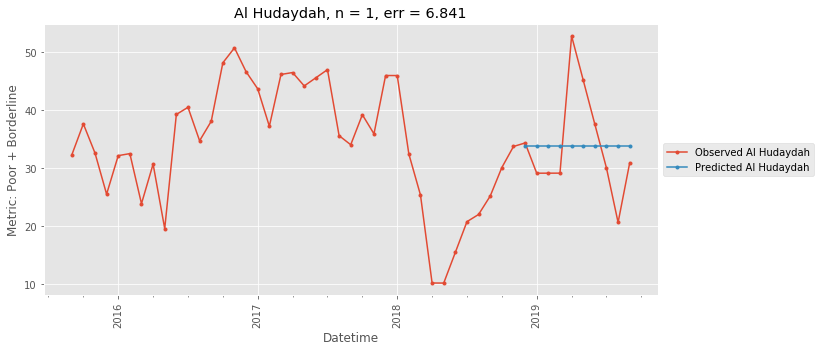

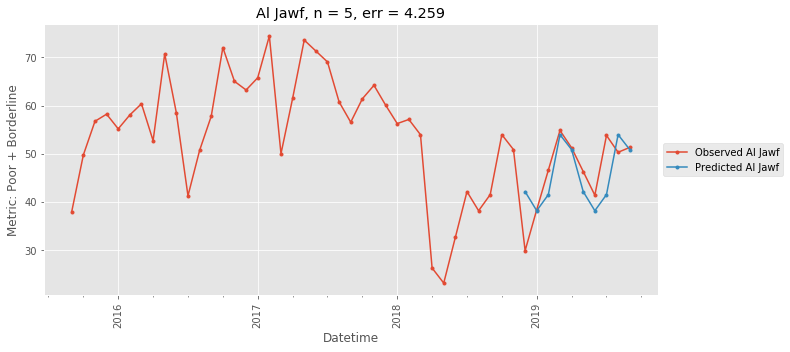

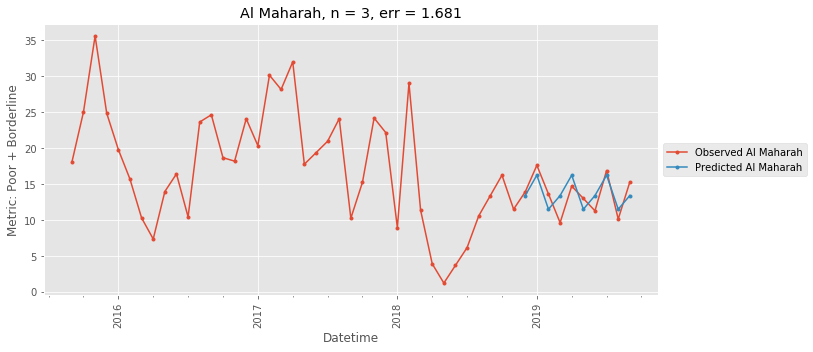

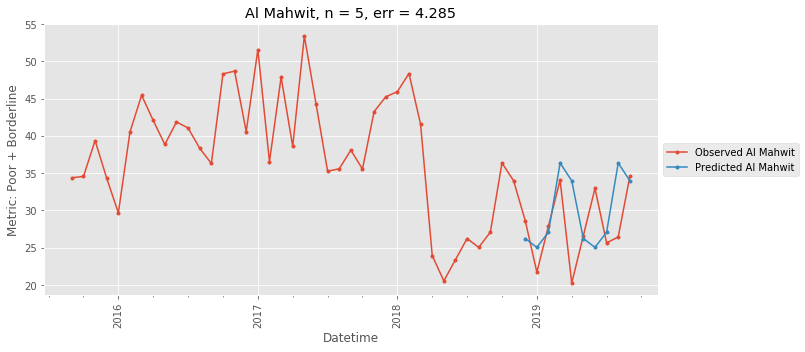

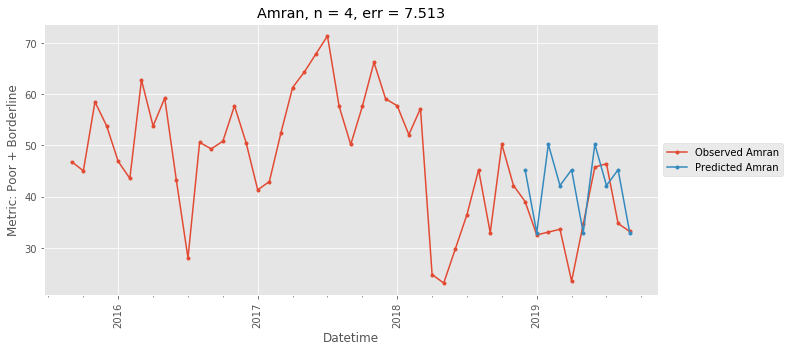

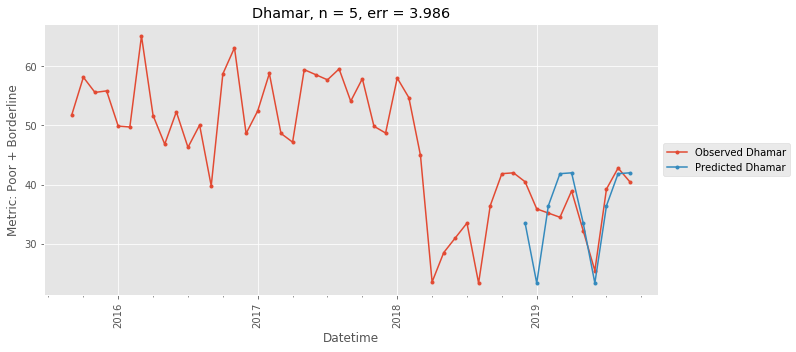

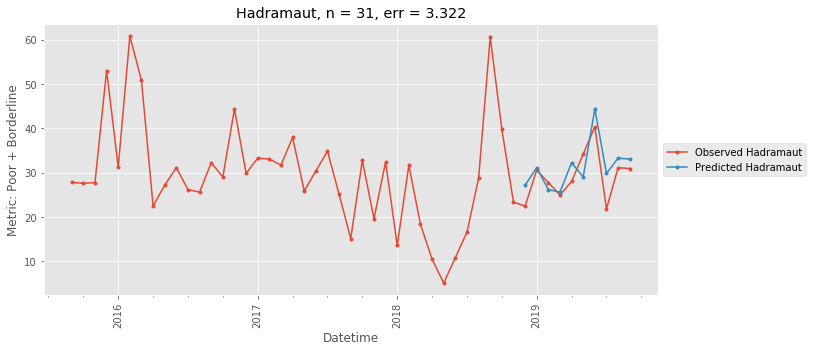

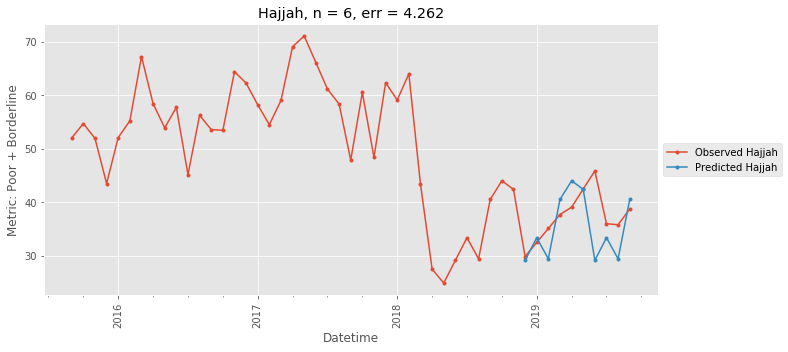

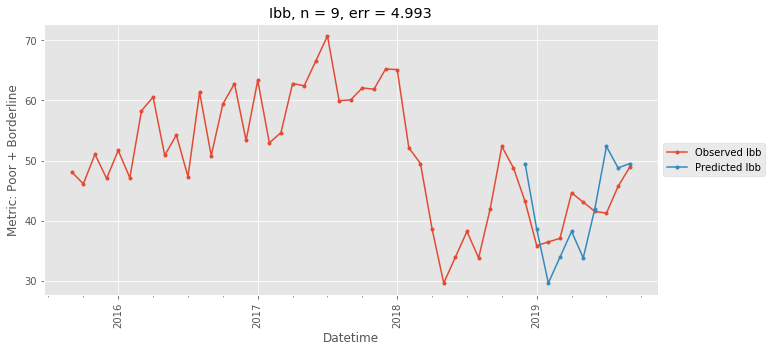

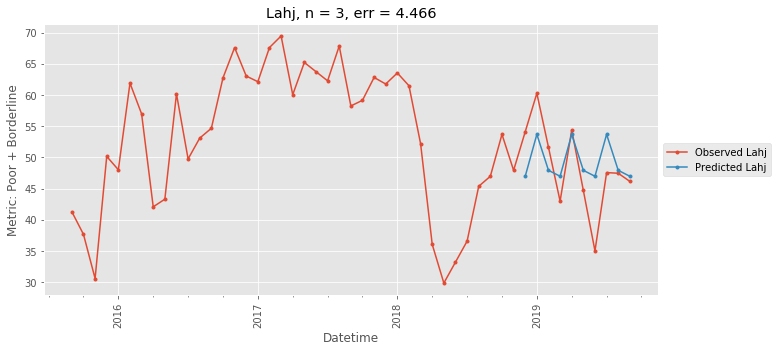

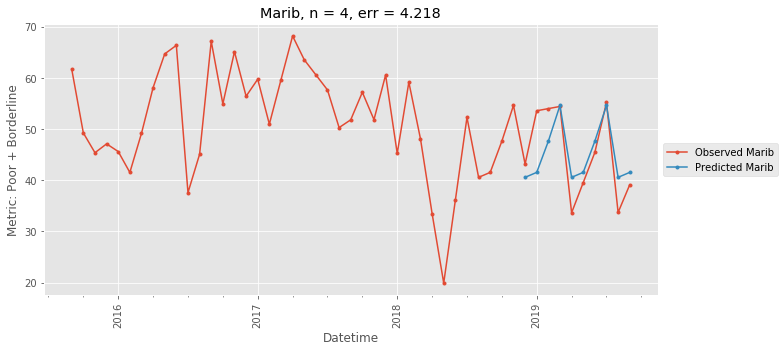

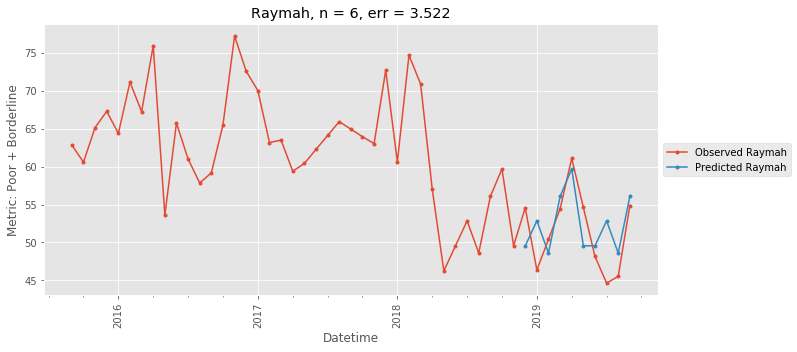

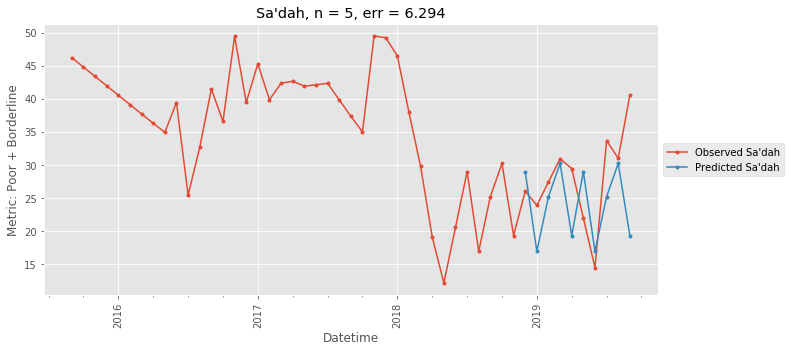

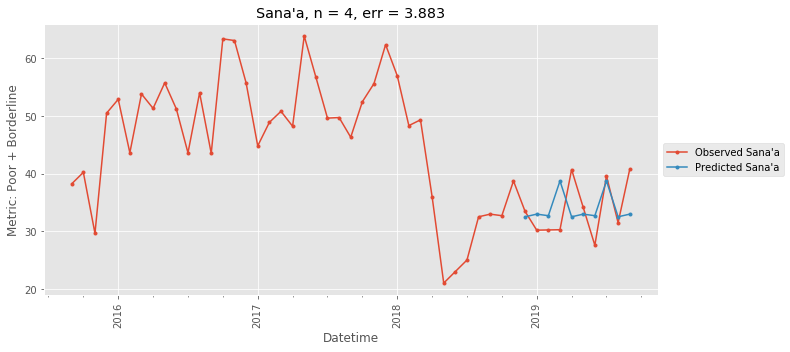

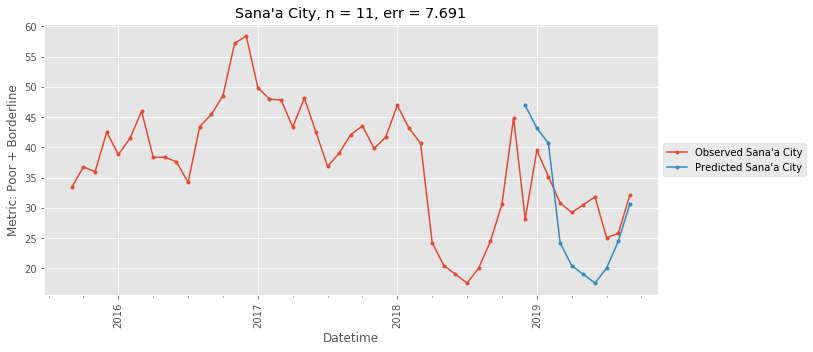

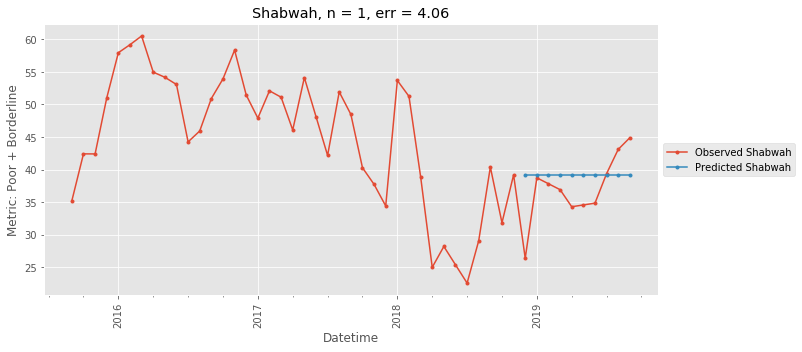

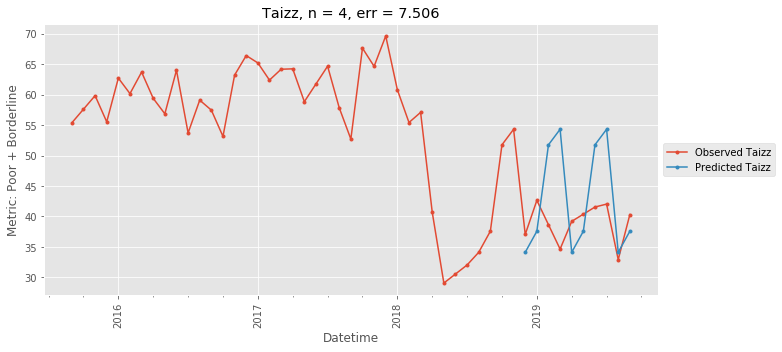

In [13]:
for result in results:
    serie_predicted = result[2]
    # Show the time-series to use.
    fig, ax = plt.subplots(figsize = (11, 5))
    plt.title(serie_predicted.name + ", " + "n = " + str(result[1]) + ", " + "err = " + str(round(result[0], 3)), 
              color = "black")
    df[serie_predicted.name].plot(ax = fig.gca(), style = ".-")
    serie_predicted.plot(ax = fig.gca(), style = ".-")
    ax.legend(["Observed " + serie_predicted.name, "Predicted " + serie_predicted.name], loc = "center left", 
              bbox_to_anchor = (1.0, 0.5))
    plt.ylabel("Metric: Poor + Borderline")
    plt.xticks(rotation = 90)
    plt.autoscale()
    plt.show()

In [14]:
results_forecast["Naive"] = err

## 2.  Average Forecast

The average model averages the last $n$ observations. Assuming for example that $n = 3$:

$$\hat{y} = \frac{x_{t - 2} + x_{t - 1} + x_t}{3}$$

where $\hat{y}$ is the prediction for the $x_{t + 1}$ value.

In [18]:
def evaluate_average_forecast(time_series, n):
    for i in range(num_predictions):
        # Make prediction.
        y_hat = np.mean(time_series[-n:])
        y_hat = pd.Series(y_hat, index = [dates_to_forecast[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    # Calculate out of samples error.
    y_hats = time_series[-num_predictions:]
    error = mean_absolute_error(df_test[time_series.name], y_hats)
    return error, n, y_hats

In [19]:
def average_forecast(time_series):    
    n_list = len(time_series)
    best_score, best_n, best_y_hats = float("inf"), None, None
    # Grid search for the best n parameter.
    for n_ in range(1, n_list + 1):
        try:
            error, n, y_hats = evaluate_average_forecast(time_series, n_)
            if error < best_score:
                best_score, best_n, best_y_hats = error, n, y_hats
        except:
            continue    
    return best_score, best_n, best_y_hats

In [20]:
df_train_copy = df_train.copy()
results = df_train_copy.apply(average_forecast)
err = np.mean([x[0] for x in results])
err

4.169709793413522

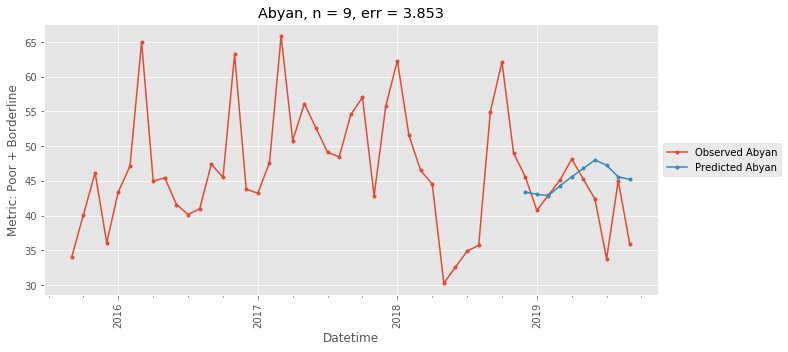

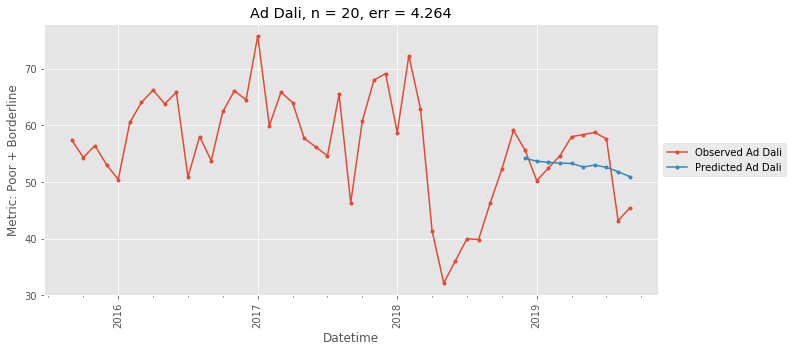

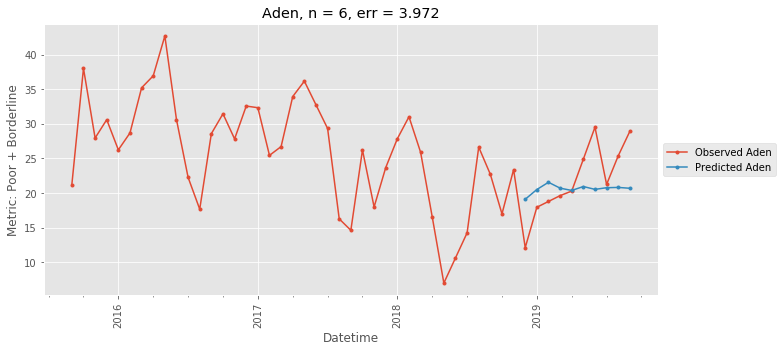

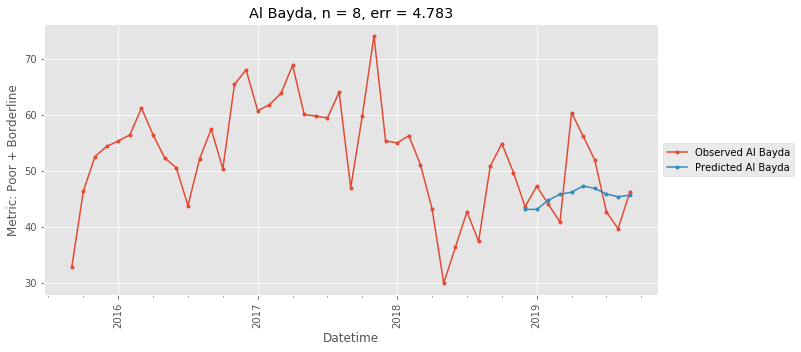

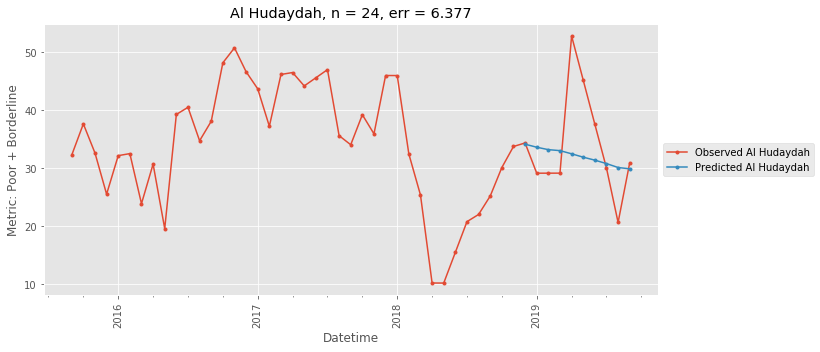

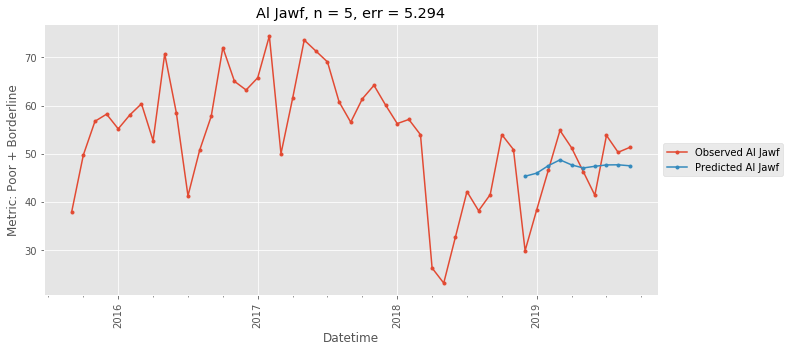

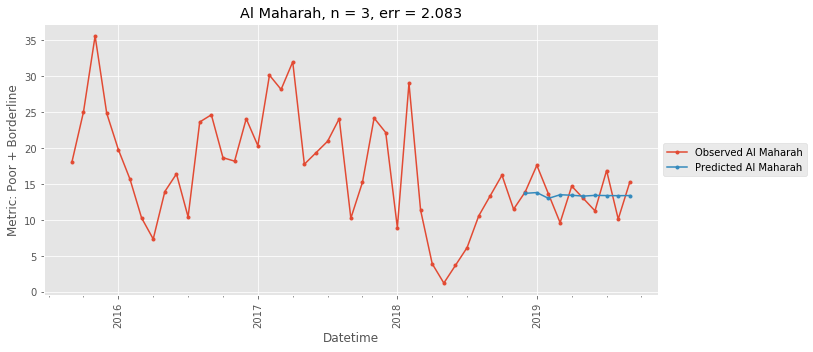

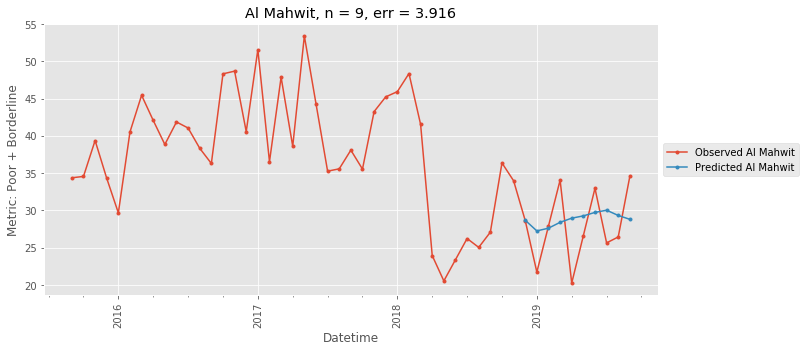

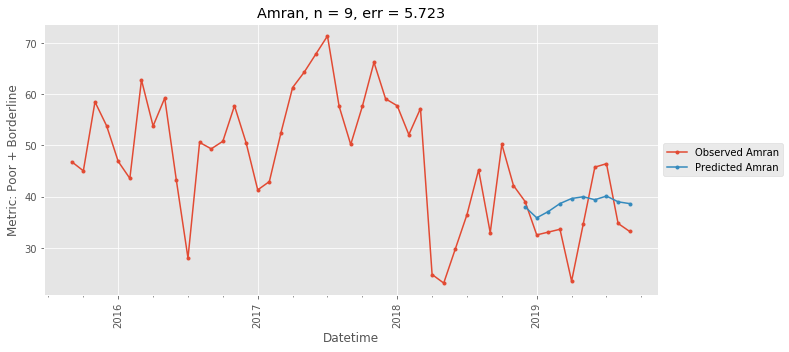

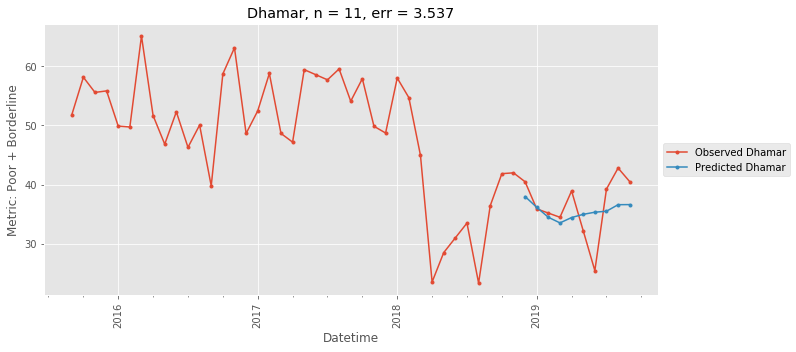

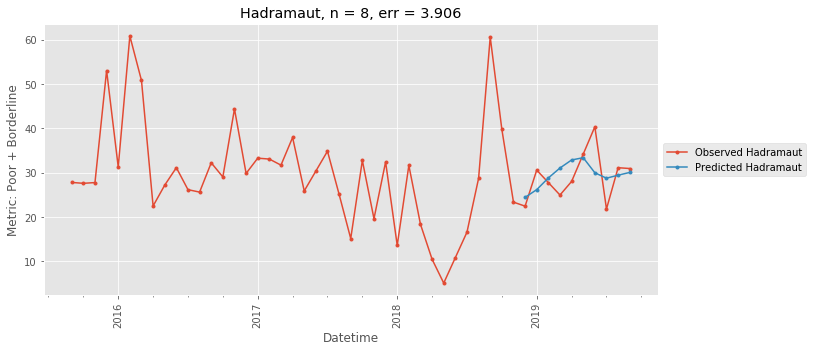

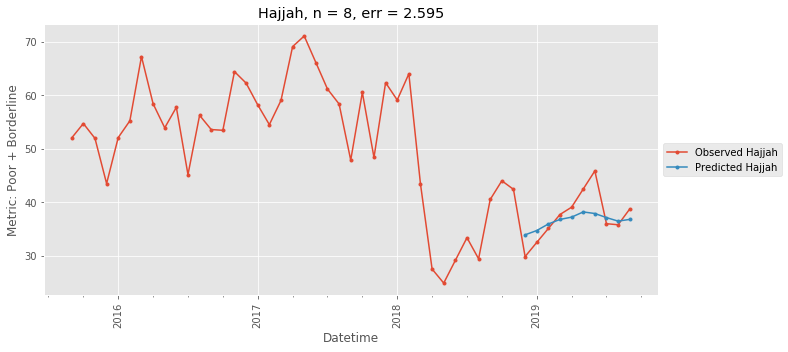

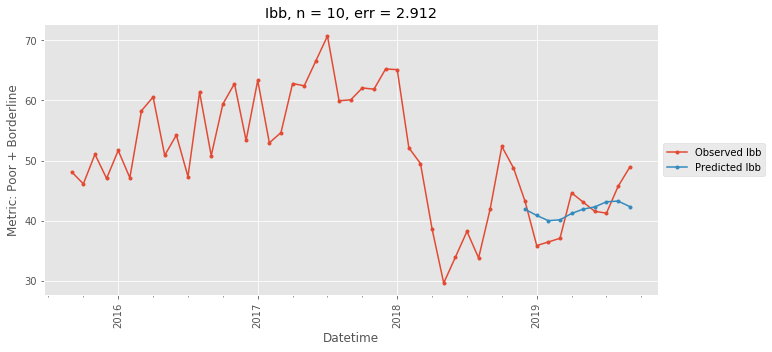

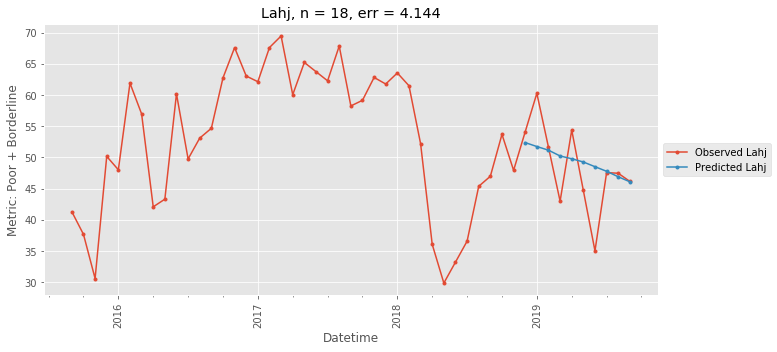

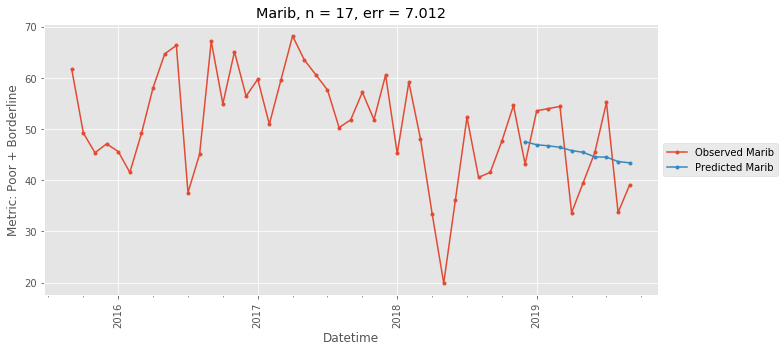

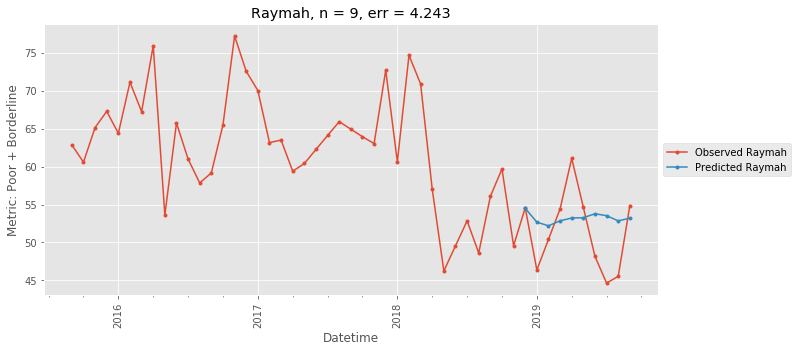

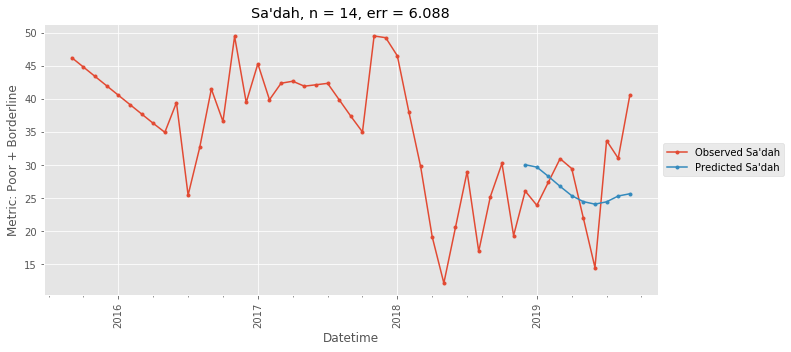

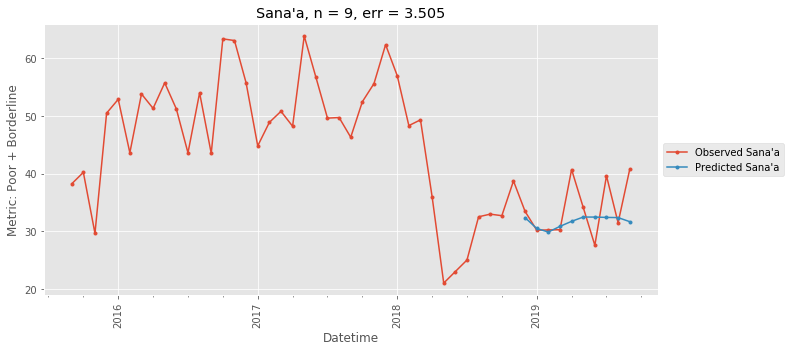

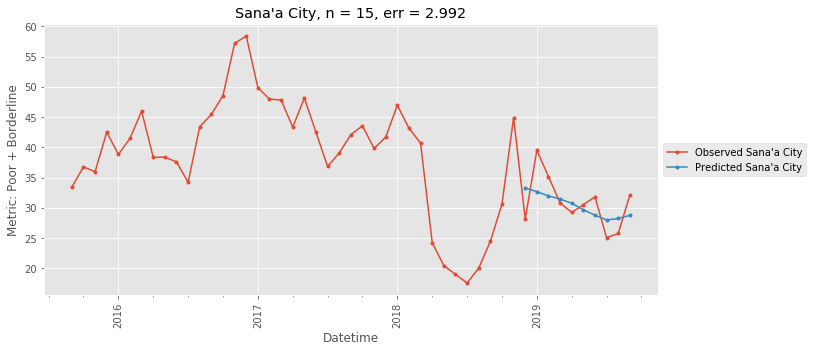

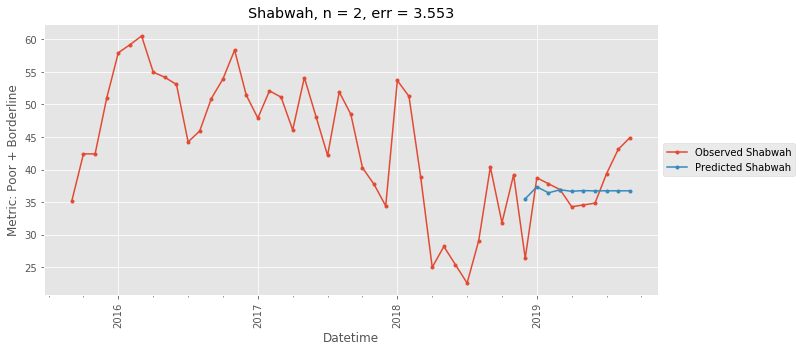

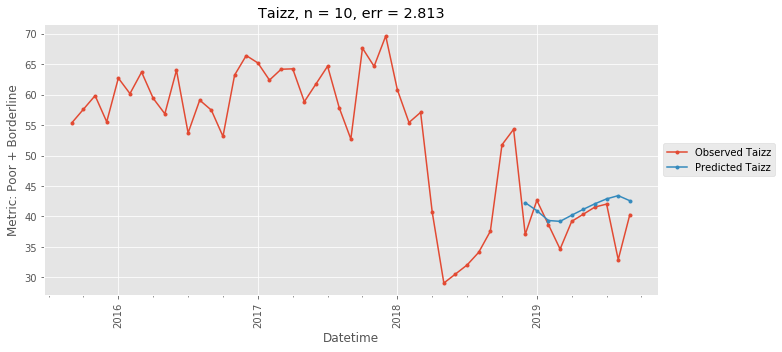

In [21]:
for result in results:
    serie_predicted = result[2]
    # Show the time-series to use.
    fig, ax = plt.subplots(figsize = (11, 5))
    plt.title(serie_predicted.name + ", " + "n = " + str(result[1]) + ", " + "err = " + str(round(result[0], 3)), 
              color = "black")
    df[serie_predicted.name].plot(ax = fig.gca(), style = ".-")
    serie_predicted.plot(ax = fig.gca(), style = ".-")
    ax.legend(["Observed " + serie_predicted.name, "Predicted " + serie_predicted.name], loc = "center left", 
              bbox_to_anchor = (1.0, 0.5))
    plt.ylabel("Metric: Poor + Borderline")
    plt.xticks(rotation = 90)
    plt.autoscale()
    plt.show()

## 3.  Autoregression (AR) Forecasting

Autoregression is a time-series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. A regression model, such as linear regression, models an output value based on a linear combination of input values (previous time step in our case). Formally, given a time-series $X = \{x_1, x_2, ..., x_t\}$, with $t$ observations, let's suppose to want to predict the next $x_{t + 1}$ value. The regression model predicts that value following a regression equation where input variables are taken from previous time steps, called *lag variables*. For example, we can predict the value for the next time step ($t + 1$) given the observations at the last two time steps ($t - 1$ and $t - 2$). As a regression model, this would look as follows:

$$\hat{y} = b_0 + b_1 x_{t - 1} + b_2  x_{t}$$

where $\hat{y}$ is the prediction for the $x_{t + 1}$ value, $b_0$, $b_1$ and $b_2$ are coefficients found by optimizing the model on training data. Because the regression model uses data from the same input variable at previous time steps, it is referred to as an autoregression (regression of self).

The statsmodels library provides an autoregression model that automatically selects an appropriate lag value (AR(p), where p is the lag value of the AR model) using statistical tests and trains a linear regression model. It is provided in the AR class.

In [29]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA

In [30]:
def evaluate_AR_forecast(time_series, n):
    for i in range(num_predictions):
        # Make prediction.
        model = ARMA(time_series, order = (n, 0))
        model_fit = model.fit()
        y_hat = model_fit.predict(start = len(time_series), end = len(time_series))
        y_hat = pd.Series(y_hat, index = [dates_to_forecast[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    # Calculate out of samples error.
    y_hats = time_series[-num_predictions:]
    error = mean_absolute_error(df_test[time_series.name], y_hats)
    return error, n, y_hats

In [31]:
def AR_forecast(time_series):
    n_list = len(time_series)
    best_score, best_n, best_y_hats = float("inf"), None, None
    # Grid search for the best n parameter.
    for n_ in range(1, n_list + 1):
        try:
            error, n, y_hats = evaluate_AR_forecast(time_series, n_)
            if error < best_score:
                best_score, best_n, best_y_hats = error, n, y_hats
        except:
            continue    
    return best_score, best_n, best_y_hats

In [ ]:
df_train_copy = df_train.copy()
results = df_train_copy.apply(AR_forecast)
err = np.mean([x[0] for x in results])
err

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information w

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creat

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoint

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information w

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoint

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information w

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information wa

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

In [ ]:
for result in results:
    serie_predicted = result[2]
    # Show the time-series to use.
    fig, ax = plt.subplots(figsize = (11, 5))
    plt.title(serie_predicted.name + ", " + "n = " + str(result[1]) + ", " + "err = " + str(round(result[0], 3)), 
              color = "black")
    df[serie_predicted.name].plot(ax = fig.gca(), style = ".-")
    serie_predicted.plot(ax = fig.gca(), style = ".-")
    ax.legend(["Observed " + serie_predicted.name, "Predicted " + serie_predicted.name], loc = "center left", 
              bbox_to_anchor = (1.0, 0.5))
    plt.ylabel("Metric: Poor + Borderline")
    plt.xticks(rotation = 90)
    plt.autoscale()
    plt.show()

In [16]:
def AR_forecast(time_series, index):
    AdminStrata = time_series.name
    Datetime = dates_to_forecast[index]
    # Train autoregression.
    model = AR(time_series)
    model_fit = model.fit()
    # Forecast.
    y_hat = model_fit.predict(start = len(time_series), end = len(time_series), dynamic = False)
    return pd.Series(y_hat, index = [Datetime], name = AdminStrata)

In [17]:
df_train_copy = df_train.copy()

for i in range(num_predictions):
    new_row = df_train_copy.apply(AR_forecast, args = [i])
    df_train_copy = df_train_copy.append(new_row)
    
df_test_predict = df_train_copy[-num_predictions:]

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

In [18]:
# Compute the total error of all the time-series predictions.
result = df_test_predict.apply(mae, args = [df_test]).mean()
result

17.90842589447591

In [19]:
results_forecast["AR"] = result

#### Stationary time-series

In [20]:
def AR_forecast_stationary(time_series, index, df_train):
    time_series, n_diff = make_stationary(time_series)
    AdminStrata = time_series.name
    Datetime = dates_to_forecast[index]
    # Train autoregression.
    model = AR(time_series)
    model_fit = model.fit()
    # Forecast.
    y_hat = model_fit.predict(start = len(time_series), end = len(time_series), dynamic = False)
    y_hat = pd.Series(y_hat, index = [Datetime], name = AdminStrata)
    y_hat = inverting_difference(y_hat, df_train, n_diff)
    return y_hat

In [21]:
df_train_copy = df_train.copy()

for i in range(num_predictions):
    new_row = df_train_copy.apply(AR_forecast_stationary, args = [i, df_train])
    df_train_copy = df_train_copy.append(new_row)
    
df_test_predict = df_train_copy[-num_predictions:]

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:

In [22]:
# Compute the total error of all the time-series predictions.
result = df_test_predict.apply(mae, args = [df_test]).mean()
result

5.889543966524528

In [23]:
results_forecast["AR_stationary"] = result

## 3.  Moving Average (MA) Forecasting

Assumes the value of the dependent variable on the current time step depends on the previous time steps error terms. The formula can be expressed as:

$$\hat{y} = \epsilon_t + \alpha_1 \epsilon_{t - 1} + \alpha_2 \epsilon_{t - 2} + ... + \alpha_q \epsilon_{t - q}$$

The value of q is called the order of the MA model. We can use the ARMA class to create an MA model and setting a zeroth-order AR model. We must specify the order of the MA model in the order argument.

In [24]:
from statsmodels.tsa.arima_model import ARMA

In [25]:
def MA_forecast(time_series, index):
    AdminStrata = time_series.name
    Datetime = dates_to_forecast[index]
    # Train autoregression.
    model = ARMA(time_series, order = (0, 2))
    model_fit = model.fit()
    # Forecast.
    y_hat = model_fit.predict(start = len(time_series), end = len(time_series))
    return pd.Series(y_hat, index = [Datetime], name = AdminStrata)

In [26]:
df_train_copy = df_train.copy()

for i in range(num_predictions):
    new_row = df_train_copy.apply(MA_forecast, args = [i])
    df_train_copy = df_train_copy.append(new_row)
    
df_test_predict = df_train_copy[-num_predictions:]

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

In [27]:
# Compute the total error of all the time-series predictions.
result = df_test_predict.apply(mae, args = [df_test]).mean()
result

6.340944990342258

In [28]:
results_forecast["MA"] = result

#### Stationary time-series

In [29]:
def MA_forecast_stationary(time_series, index, df_train):
    time_series, n_diff = make_stationary(time_series)
    AdminStrata = time_series.name
    Datetime = dates_to_forecast[index]
    # Train autoregression.
    model = ARMA(time_series, order = (0, 2))
    model_fit = model.fit()
    # Forecast.
    y_hat = model_fit.predict(start = len(time_series), end = len(time_series), dynamic = False)
    y_hat = pd.Series(y_hat, index = [Datetime], name = AdminStrata)
    y_hat = inverting_difference(y_hat, df_train, n_diff)
    return y_hat

In [30]:
df_train_copy = df_train.copy()

for i in range(num_predictions):
    new_row = df_train_copy.apply(MA_forecast_stationary, args = [i, df_train])
    df_train_copy = df_train_copy.append(new_row)
    
df_test_predict = df_train_copy[-num_predictions:]

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred 

In [31]:
# Compute the total error of all the time-series predictions.
result = df_test_predict.apply(mae, args = [df_test]).mean()
result

5.964325610894773

In [32]:
results_forecast["MA_stationary"] = result

## 4.  Autoregressive Moving Average (ARMA) Forecasting

The Autoregressive Moving Average (ARMA) method models the next step in the sequence as a linear function of the observations and resiudal errors at prior time steps.

It combines both Autoregression (AR) and Moving Average (MA) models:

$$\hat{y} = \epsilon_t + \alpha_1 \epsilon_{t - 1} + \alpha_2 \epsilon_{t - 2} + ... + \alpha_q \epsilon_{t - q} + b_0 + b_1 x_{t} + b_2  x_{t - 1} + ... + b_p x_{t - p}$$

In [33]:
def ARMA_forecast(time_series, index):
    AdminStrata = time_series.name
    Datetime = dates_to_forecast[index]
    # Train autoregression.
    model = ARMA(time_series, order = (2, 1))
    model_fit = model.fit()
    # Forecast.
    y_hat = model_fit.predict(start = len(time_series), end = len(time_series))
    return pd.Series(y_hat, index = [Datetime], name = AdminStrata)

In [34]:
df_train_copy = df_train.copy()

for i in range(num_predictions):
    new_row = df_train_copy.apply(ARMA_forecast, args = [i])
    df_train_copy = df_train_copy.append(new_row)
    
df_test_predict = df_train_copy[-num_predictions:]

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:1

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred f

In [35]:
# Compute the total error of all the time-series predictions.
result = df_test_predict.apply(mae, args = [df_test]).mean()
result

5.426726063243366

In [36]:
results_forecast["ARMA"] = result

#### Stationary time-series

In [37]:
def ARMA_forecast_stationary(time_series, index, df_train):
    time_series, n_diff = make_stationary(time_series)
    AdminStrata = time_series.name
    Datetime = dates_to_forecast[index]
    # Train autoregression.
    model = ARMA(time_series, order = (2, 1))
    model_fit = model.fit()
    # Forecast.
    y_hat = model_fit.predict(start = len(time_series), end = len(time_series), dynamic = False)
    y_hat = pd.Series(y_hat, index = [Datetime], name = AdminStrata)
    y_hat = inverting_difference(y_hat, df_train, n_diff)
    return y_hat

In [38]:
df_train_copy = df_train.copy()

for i in range(num_predictions):
    new_row = df_train_copy.apply(ARMA_forecast_stationary, args = [i, df_train])
    df_train_copy = df_train_copy.append(new_row)
    
df_test_predict = df_train_copy[-num_predictions:]

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:1

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred f

In [39]:
# Compute the total error of all the time-series predictions.
result = df_test_predict.apply(mae, args = [df_test]).mean()
result

5.675007386967149

In [40]:
results_forecast["ARMA_stationary"] = result

## 5.  Autoregressive Integrated Moving Average (ARIMA) Forecasting

The Autoregressive Integrated Moving Average (ARIMA) method models the next step in the sequence as a linear function of the differenced observations and residual errors at prior time steps.

It combines both Autoregression (AR) with p order and Moving Average (MA) with q order models as well as a differencing pre-processing step of the sequence to make the sequence stationary, called integration (I) with d order.

The user must specify a tuple of p, d, and q ARIMA parameters. We want to perform a grid search for finding the best setting of these parameters. The statsmodels ARIMA procedure internally uses numerical optimization procedures to find a set of coefficients for the model. These procedures can fail, which in turn can throw an exception. We must catch these exceptions and skip those configurations that cause a problem. 

In [41]:
from statsmodels.tsa.arima_model import ARIMA
import itertools
import warnings
warnings.filterwarnings("ignore")

In [42]:
def evaluate_ARIMA_model(time_series, arima_order):
    for i in range(num_predictions):
        # Make prediction.
        model = ARIMA(time_series, order = arima_order)
        model_fit = model.fit()
        y_hat = model_fit.forecast()[0]
        y_hat = pd.Series(y_hat, index = [dates_to_forecast[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    # Calculate out of samples error.
    predictions = time_series[-num_predictions:]
    error = mean_absolute_error(df_test[time_series.name], predictions)
    return error

In [43]:
def ARIMA_forecast(time_series):
    # Grid search of the p, d and q parameters of the ARIMA model.
    p = d = q = range(0, 3)
    # All the combination of the parameters.
    arima_orders = list(itertools.product(p, d, q))
    best_score, best_arima_order = float("inf"), None
    for arima_order in arima_orders:
        try:
            error = evaluate_ARIMA_model(time_series, arima_order)
            if error < best_score:
                best_score = error
        except:
            continue    
    # Forecast.
    return best_score

In [44]:
df_train_copy = df_train.copy()
result = df_train_copy.apply(ARIMA_forecast).mean()
result

3.171312305119907

In [45]:
results_forecast["ARIMA"] = result

#### Stationary time-series

In [46]:
def evaluate_ARIMA_model_stationary(time_series, arima_order, n_diff):
    for i in range(num_predictions):
        # Make prediction.
        model = ARIMA(time_series, order = arima_order)
        model_fit = model.fit()
        y_hat = model_fit.forecast()[0]
        y_hat = pd.Series(y_hat, index = [dates_to_forecast[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    # Calculate out of sample error.
    predictions = time_series[-num_predictions:]
    predictions = inverting_difference(predictions, df_train, n_diff)
    error = mean_absolute_error(df_test[time_series.name], predictions)
    return error

In [47]:
def ARIMA_forecast_stationary(time_series):
    # Make the time-series stationary if need it.
    time_series, n_diff = make_stationary(time_series)
    # Grid search of the p, d and q parameters.
    p = d = q = range(0, 3)
    arima_orders = list(itertools.product(p, d, q))
    best_score, best_arima_order = float("inf"), None
    for arima_order in arima_orders:
        try:
            error = evaluate_ARIMA_model_stationary(time_series, arima_order, n_diff)
            if error < best_score:
                best_score = error
        except:
            continue    
    # Forecast.
    return best_score

In [48]:
df_train_copy = df_train.copy()
result = df_train_copy.apply(ARIMA_forecast_stationary).mean()
result

3.3677709077448914

In [49]:
results_forecast["ARIMA_stationary"] = result

## 6.  Seasonal Autoregressive Integrated Moving Average (ARIMA) Forecasting

The Seasonal Autoregressive Integrated Moving Average, or SARIMA, model is an approach for modeling univariate time-series data that may contain trend and seasonal components. It is an effective approach for time-series forecasting, although it requires careful analysis and domain expertise in order to configure the seven or more model hyperparameters. An alternative approach to configuring the model is to grid search a suite of hyperparameter configurations in order to discover what works best.

In [98]:
import statsmodels.api as sm

In [99]:
def evaluate_SARIMAX_model(time_series, arima_order, seasonal_order):
    for i in range(num_predictions):
        # Make prediction.
        model = sm.tsa.statespace.SARIMAX(time_series, order = arima_order,
                                          seasonal_order = seasonal_order,
                                          enforce_stationarity = False,
                                          enforce_invertibility = False)
        model_fit = model.fit()
        y_hat = model_fit.predict(len(time_series), len(time_series))[0]
        y_hat = pd.Series(y_hat, index = [dates_to_forecast[i]], name = time_series.name)
        time_series = time_series.append(y_hat)
    # Calculate out of samples error.
    predictions = time_series[-num_predictions:]
    error = mean_absolute_error(df_test[time_series.name], predictions)
    return error

In [100]:
def SARIMAX_forecast(time_series):
    # Grid search of the p, d and q parameters of the SARIMA model.
    p = d = q = range(0, 2)
    # All the combination of the parameters.
    arima_orders = list(itertools.product(p, d, q))
    seasonal_orders = [(x[0], x[1], x[2], 12) for x in arima_orders]
    best_score, best_arima_order = float("inf"), None
    for arima_order in arima_orders:
        for seasonal_order in seasonal_orders:
            try:
                error = evaluate_SARIMAX_model(time_series, arima_order, seasonal_order)
                if error < best_score:
                    best_score = error
            except:
                continue    
    # Forecast.
    return best_score

In [101]:
df_train_copy = df_train.copy()
result = df_train_copy.apply(SARIMAX_forecast).mean()
result

4.735845159726082

In [60]:
results_forecast["SARIMA_stationary"] = result

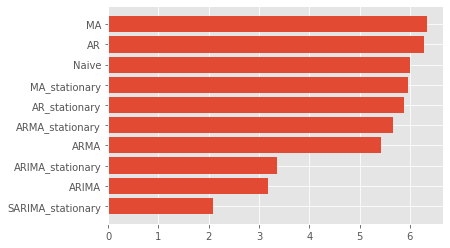

In [61]:
results_forecast = dict(sorted(results_forecast.items(), key = lambda x: x[1]))
plt.barh(*zip(*results_forecast.items()))
plt.show()

In [4]:
def series_to_supervised(df, n_in = 1, n_out = 1):
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [("%s (t-%d)" % (name, i)) for name in df.keys()]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [("%s (t)" % (name)) for name in df.keys()]
        else:
            names += [("%s (t+%d)" % (name, i)) for name in df.keys()]
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    return agg

In [5]:
n_in = 1

In [6]:
def time_series_to_keep(df, AdminStrata):
    time_series = list()
    # Add the time-series used as X.
    for i in range(n_in, -1, -1):
        if i > 0:
            time_series.extend(list(df.columns.values + " (t-" + str(i) + ")"))
    # Add the time-series used as y.
    time_series.append(AdminStrata + " (t)")
    return time_series

In [7]:
df_train = series_to_supervised(ts_fcs[:len(ts_fcs) - 1], n_in).dropna()[time_series_to_keep(ts_fcs, "Aden")]
df_train.head()

,Abyan (t-1),Ad Dali (t-1),Aden (t-1),Al Bayda (t-1),Al Hudaydah (t-1),Al Jawf (t-1),Al Maharah (t-1),Al Mahwit (t-1),Amran (t-1),Dhamar (t-1),...,Ibb (t-1),Lahj (t-1),Marib (t-1),Raymah (t-1),Sa'dah (t-1),Sana'a (t-1),Sana'a City (t-1),Shabwah (t-1),Taizz (t-1),Aden (t)
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-10-31,34.100,57.43,21.22,32.76,32.28,37.97,18.00,34.38,46.82,51.76,...,48.10,41.31,61.71,62.84,46.230000,38.25,33.43,35.22,55.37,38.02
2015-11-30,40.145,54.33,38.02,46.39,37.67,49.74,25.00,34.56,45.05,58.15,...,46.12,37.69,49.25,60.59,44.811429,40.24,36.76,42.42,57.60,27.95
2015-12-31,46.190,56.44,27.95,52.56,32.65,56.74,35.56,39.38,58.51,55.58,...,51.04,30.62,45.39,65.15,43.392857,29.66,35.96,42.41,59.83,30.60
2016-01-31,36.110,53.04,30.60,54.37,25.54,58.22,24.82,34.31,53.84,55.84,...,47.02,50.17,47.12,67.28,41.974286,50.51,42.51,51.00,55.53,26.24
2016-02-29,43.440,50.44,26.24,55.33,32.19,55.17,19.78,29.67,46.88,49.89,...,51.67,48.03,45.62,64.38,40.555714,52.91,38.82,57.95,62.71,28.68


In [8]:
dataset = df_train.values
dataset

array([[34.1  , 57.43 , 21.22 , ..., 35.22 , 55.37 , 38.02 ],
       [40.145, 54.33 , 38.02 , ..., 42.42 , 57.6  , 27.95 ],
       [46.19 , 56.44 , 27.95 , ..., 42.41 , 59.83 , 30.6  ],
       ...,
       [45.25 , 58.385, 24.895, ..., 34.575, 40.375, 29.51 ],
       [42.37 , 58.76 , 29.51 , ..., 34.85 , 41.55 , 21.24 ],
       [33.78 , 57.6  , 21.24 , ..., 39.39 , 42.03 , 25.37 ]])

In [9]:
X = dataset[:, :-1]
y = dataset[:, -1]
print(X.shape)
print(y.shape)

(47, 21)
(47,)


In [16]:
X_test = series_to_supervised(ts_fcs.tail(n_in + 1).append(pd.Series(), ignore_index = True), n_in).tail(2).head(1).dropna(axis = 1)[time_series_to_keep(ts_fcs, "Aden")].iloc[ :, :-1].values
X_test = X_test.flatten()
X_test

array([45.02, 43.16, 25.37, 39.67, 20.66, 50.3 , 10.12, 26.44, 34.78,
       42.8 , 31.13, 35.78, 45.7 , 47.47, 33.71, 45.54, 31.01, 31.5 ,
       25.77, 43.11, 32.92])

In [17]:
n_features = 1
n_steps = X.shape[1]

In [38]:
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = tf.keras.models.Sequential() 
model.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
history = model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
#x_input = array([70, 80, 90])
#x_input = x_input.reshape((1, n_steps, n_features))

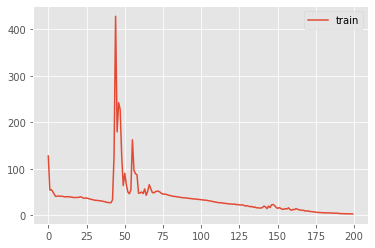

In [39]:
# Plot history.
plt.plot(history.history['loss'], label = 'train')
plt.legend()
plt.show()

In [40]:
x_input = X_test
x_input = x_input.reshape((1, n_steps, n_features))

In [41]:
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[22.579395]]
